In [1]:
#tensorflow
import tensorflow as tf
from tensorflow.python.client import device_lib

#keras
import keras
from keras.backend.tensorflow_backend import set_session
from keras import models
from keras import layers
from keras import regularizers
from keras import backend as K
from keras.optimizers import RMSprop
from keras import callbacks

#numpy
import numpy as np

#matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

import math as math

#time
import time

Using TensorFlow backend.


In [2]:
config = tf.ConfigProto()
# dynamically grow the memory used on the GPU
config.gpu_options.allow_growth = True  
config.log_device_placement = False
sess = tf.Session(config=config)
set_session(sess)
print(tf.__version__)
print(keras.__version__)
print(device_lib.list_local_devices())

1.10.0
2.2.4
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15148548933757947220
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4960052838
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16624540109592170916
physical_device_desc: "device: 0, name: GeForce GTX 1060, pci bus id: 0000:02:00.0, compute capability: 6.1"
]


In [3]:
'''
Zufallig verteilte punktemenge mit der Klassifikation, ob der Punk über oder
unter dem sin(x) liegt
'''
def get_data(amount = 1000000, start=0):
    my_point = np.random.rand(amount,2)
    # x Koordinaten von [0 : 2π] + start
    my_point[: , 0] = my_point[: , 0] * math.pi * 2 + start
    # y Koordinate von [-1 : 1]
    my_point[: , 1] = my_point[: , 1] * 2 - 1  

    my_classification = np.asarray([1 if math.sin(x) > y else 0 for x, y in my_point]).astype('float32')
    
    return (my_point, my_classification)

In [4]:
point,classification = get_data()

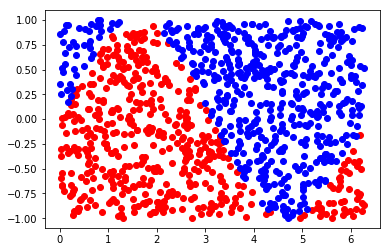

In [8]:
d_point = point[:1000]

p_x = []
p_y = []
n_x = []
n_y = []

for index, tmp in enumerate(d_point):
    if(classification[index] == 1):
        p_x.append(tmp[0])
        p_y.append(tmp[1])
    else:
        n_x.append(tmp[0])
        n_y.append(tmp[1])


plt.plot(p_x , p_y, 'ro')
plt.plot(n_x , n_y, 'bo')
plt.show()


In [9]:
model = models.Sequential()
model.add(layers.Dense(4, activation='sigmoid', input_shape=(2,)))
model.add(layers.Dense(4, activation='sigmoid'))
model.add(layers.Dense(1 , activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 4)                 12        
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 5         
Total params: 37
Trainable params: 37
Non-trainable params: 0
_________________________________________________________________


In [16]:
learning_rate_reduction = callbacks.ReduceLROnPlateau(
                                            # val_acc zeigt die letzten verlusraten
                                            monitor='val_acc', 
                                            # wie lange halten wir die Fuesse still, bevor wir die Lernrate anpassen
                                            patience=3, 
                                            verbose=1,
                                            # Die lernrate wird halbiert
                                            factor=0.5, 
                                            # ab wann brechen wir ab
                                            min_lr=0.00001)

early_stopping = callbacks.EarlyStopping(
                                            # über welchen Monitor beobachtet man die Änderung der letzten Iterationen?
                                            monitor = 'acc',
                                            # wie lange halten wir die Fuesse still, bis wir das Lernen abbrechen
                                            patience = 1)


start = time.time()
history  = model.fit(point, 
                     classification, 
                     epochs=4, 
                     batch_size=128, 
                     validation_split=0.2, 
                     shuffle=True,  
                     callbacks=[learning_rate_reduction, early_stopping])
print("It took:", time.time() - start)

Train on 800000 samples, validate on 200000 samples
Epoch 1/4
800000/800000 [==============================] - 28s 35us/step - loss: 0.3825 - acc: 0.8422 - val_loss: 0.2921 - val_acc: 0.8569
Epoch 2/4
800000/800000 [==============================] - 27s 34us/step - loss: 0.2163 - acc: 0.9049 - val_loss: 0.1548 - val_acc: 0.9339
Epoch 3/4
800000/800000 [==============================] - 27s 33us/step - loss: 0.1319 - acc: 0.9447 - val_loss: 0.1099 - val_acc: 0.9584
Epoch 4/4
800000/800000 [==============================] - 29s 36us/step - loss: 0.0883 - acc: 0.9717 - val_loss: 0.0687 - val_acc: 0.9819
It took: 110.33750867843628


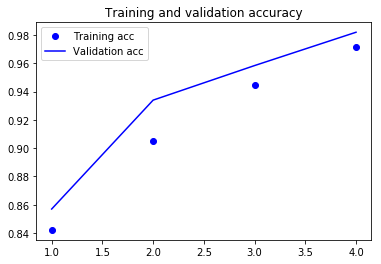

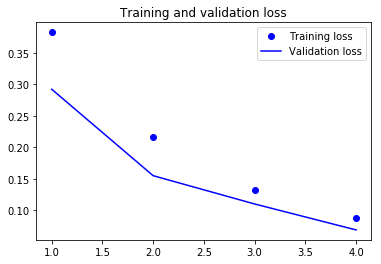

In [17]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [18]:
test_point, test_classification = get_data(amount=10000)
(test_loss, test_acc) = model.evaluate(test_point, test_classification)
print("Loss: ", test_loss)
print("Accuracy: ", test_acc)

10000/10000 [==============================] - 1s 80us/step
Loss:  0.0701162370145321
Accuracy:  0.981


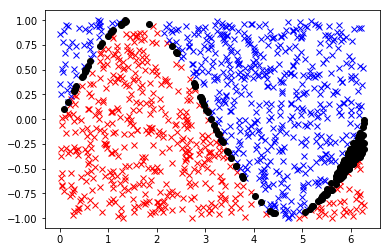

In [19]:
pred_classification = model.predict(test_point)

wrong_x = []
wrong_y = []

for index, temp_classification in enumerate(pred_classification):
    temp_classification = 1 if temp_classification >= 0.5 else 0
    if(temp_classification != test_classification[index]):
        wrong_x.append(test_point[index][0])
        wrong_y.append(test_point[index][1])


plt.plot(p_x , p_y, 'rx')
plt.plot(n_x , n_y, 'bx')
plt.plot(wrong_x , wrong_y, 'ko')
plt.show()